In [1]:
import numpy as np
import pandas as pd
import psycopg2
import dotenv
import os
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import HTML

from mplsoccer import Pitch



dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# Database connection parameters
import psycopg2
import os

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)

# ballquery="""
# SELECT pt.period_id, pt.frame_id, pt.timestamp, pt.x, pt.y, pt.player_id, p.team_id
# FROM player_tracking pt
# JOIN players p ON pt.player_id = p.player_id
# JOIN teams t ON p.team_id = t.team_id
# WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg' AND p.player_id = 'ball' AND pt.period_id = 1
# ORDER BY timestamp;
# """
# # Differentiating teams logic
# team_query = """
# SELECT DISTINCT p.team_id
# FROM player_tracking pt
# JOIN players p ON pt.player_id = p.player_id
# JOIN teams t ON p.team_id = t.team_id AND p.player_id != 'ball'
# WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
# """
# team_ids_df = pd.read_sql_query(team_query, conn)  # Fetch the query result as a DataFrame
# # Extract the team IDs as a list
# team_ids = team_ids_df['team_id'].tolist()




# teamqueries = """
# SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.team_id
# FROM player_tracking pt
# JOIN players p ON pt.player_id = p.player_id
# JOIN teams t ON p.team_id = t.team_id
# WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg' AND p.player_id != 'ball' AND p.team_id = %s
# ORDER BY timestamp;
# """



# df_ball = pd.read_sql_query(ballquery,conn)
# df_home = pd.read_sql_query(teamqueries, conn, params=(team_ids[0],))
# df_away = pd.read_sql_query(teamqueries, conn, params=(team_ids[1],))

# # First set up the figure, the axis
# pitch = Pitch(pitch_type='metricasports', goal_type='line', pitch_width=68, pitch_length=105)
# fig, ax = pitch.draw(figsize=(16, 10.4))

# # then setup the pitch plot markers we want to animate
# marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
# ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
# away, = ax.plot([], [], ms=10, markerfacecolor='#b94b75', **marker_kwargs)  # red/maroon
# home, = ax.plot([], [], ms=10, markerfacecolor='#7f63b8', **marker_kwargs)  # purple

# our_number = 1722798900000
# # animation function
# def animate(i):
#     """ Function to animate the data. Each frame it sets the data for the players and the ball."""
#     # set the ball data with the x and y positions for the ith frame
#     ball.set_data([df_ball.iloc[i]['x']/100],
#                   [df_ball.iloc[i]['y']/100])
    
   

#     frame = df_ball.iloc[i, 1]
#     #print(frame)

#     # set the player data using the frame id
#     away.set_data(df_away.loc[df_away.frame_id == frame, 'x']/100,
#                   df_away.loc[df_away.frame_id == frame, 'y']/100)
#     home.set_data(df_home.loc[df_home.frame_id == frame, 'x']/100,
#                   df_home.loc[df_home.frame_id == frame, 'y']/100)
#     return ball, away, home


# # call the animator, animate so 25 frames per second
# anim = animation.FuncAnimation(fig, animate, frames=len(df_ball), interval=20, blit=True)
# HTML(anim.to_jshtml())






In [2]:
def get_tracking_data(match_id, duration=5):
    """Get player and ball tracking data for a time window"""
    
    # Query for player positions
    player_query = """
    SELECT 
        pt.frame_id,
        pt.timestamp,
        pt.period_id,
        pt.player_id,
        p.jersey_number,
        p.team_id,
        pt.x,
        pt.y
    FROM 
        player_tracking pt
    JOIN 
        players p ON pt.player_id = p.player_id
    WHERE 
        pt.game_id = %s
    ORDER BY 
        pt.frame_id, p.team_id
    """
    
    # Query for ball positions
    ball_query = """
    SELECT 
        pt.frame_id,
        pt.timestamp,
        pt.period_id,
        NULL AS player_id,
        NULL AS jersey_number,
        NULL AS team_id,
        pt.x,
        pt.y
    FROM 
        player_tracking pt
    WHERE 
        pt.game_id = %s
        AND pt.player_id = 'ball'
    ORDER BY 
        pt.frame_id
    """
    
    # Execute queries with proper parameter passing
    players_df = pd.read_sql_query(
        player_query, 
        conn, 
        params=(match_id,)  # Note the comma to make it a tuple
    )
    
    ball_df = pd.read_sql_query(
        ball_query, 
        conn, 
        params=(match_id,)  # Note the comma to make it a tuple
    )
    
    if players_df.empty or ball_df.empty:
        print(f"No data found for match_id: {match_id}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # Get team information
    team_ids = players_df['team_id'].unique()
    if len(team_ids) >= 2:
        home_team_id = players_df['team_id'].value_counts().index[0]
        away_team_id = players_df['team_id'].value_counts().index[1]
        
        # Split players by team
        home_df = players_df[players_df['team_id'] == home_team_id].copy()
        away_df = players_df[players_df['team_id'] == away_team_id].copy()
        
        # Add Frame column to match animation code
        home_df['Frame'] = home_df['frame_id']
        away_df['Frame'] = away_df['frame_id']
        ball_df['Frame'] = ball_df['frame_id']
        
        return home_df, away_df, ball_df
    else:
        print(f"Not enough teams found for match_id: {match_id}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [3]:
home_df, away_df, ball_df = get_tracking_data("5uts2s7fl98clqz8uymaazehg", duration=5)
print("Home Team DataFrame:\n", home_df)


Home Team DataFrame:
              frame_id        timestamp  period_id                  player_id  \
1       1722798900000  0 days 00:00:00          1   pi2sxs616a52jvpfywgwjowl   
2       1722798900000  0 days 00:00:00          1   8lqo2ajhgjockasmd198nai1   
3       1722798900000  0 days 00:00:00          1  2961iy0sg9zmy0r6fzbr2dmg9   
4       1722798900000  0 days 00:00:00          1  5j8jlykegiplbh3tr6zed88a1   
5       1722798900000  0 days 00:00:00          1  77px2f7a0ihv8dchncdfj7r9x   
...               ...              ...        ...                        ...   
135500  1722805622280  00:52:02.280000          2  adgdnh26ntaid4lweet3z0mi1   
135501  1722805622280  00:52:02.280000          2  5j8jlykegiplbh3tr6zed88a1   
135502  1722805622280  00:52:02.280000          2   pi2sxs616a52jvpfywgwjowl   
135503  1722805622280  00:52:02.280000          2  dxcsuw39xzusjsj5e1jw53y6t   
135504  1722805622280  00:52:02.280000          2  2hr7skflmxmpiiauz04h185ey   

        jersey_nu

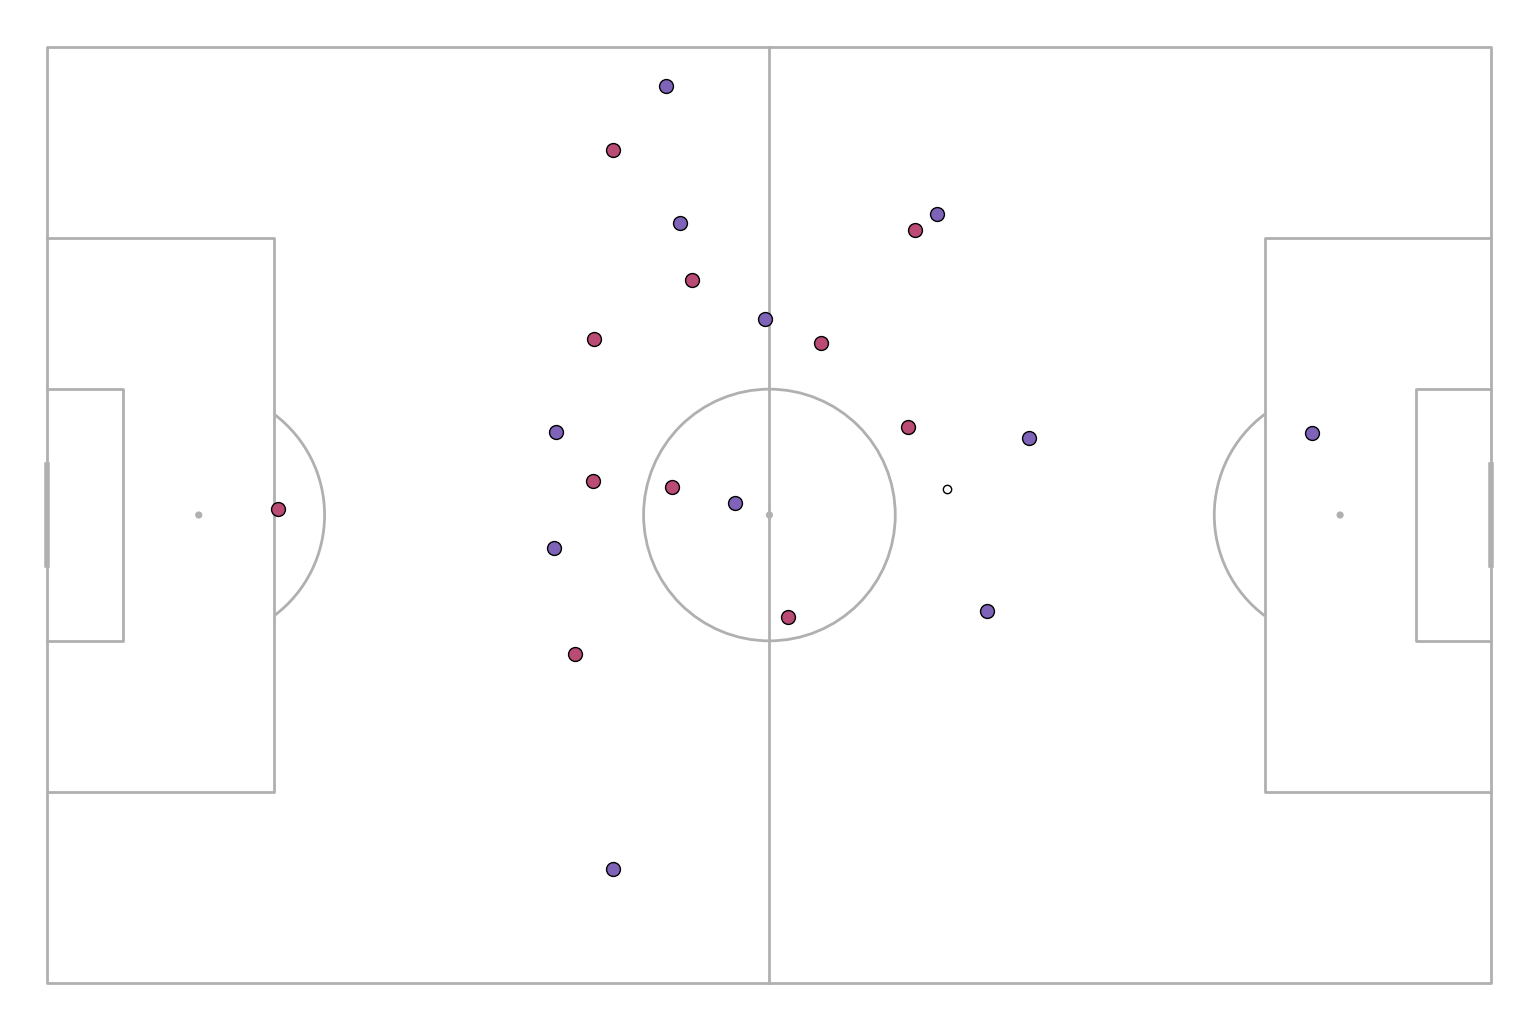

In [9]:
pitch = Pitch(pitch_type='metricasports', goal_type='line', pitch_width=68, pitch_length=105)
fig, ax = pitch.draw(figsize=(16, 10.4))

# then setup the pitch plot markers we want to animate
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away, = ax.plot([], [], ms=10, markerfacecolor='#b94b75', **marker_kwargs)  # red/maroon
home, = ax.plot([], [], ms=10, markerfacecolor='#7f63b8', **marker_kwargs)  # purple


# animation function
def animate(i):
    """ Function to animate the data. Each frame it sets the data for the players and the ball."""
    # set the ball data with the x and y positions for the ith frame
    ball.set_data([ball_df.iloc[i]['x']/100],
                  [ball_df.iloc[i]['y']/100])
    
   

    frame = ball_df.iloc[i,0]
    
  

    # set the player data using the frame id
    away.set_data(away_df.loc[away_df['Frame'] == frame, 'x']/100,
                  away_df.loc[away_df['Frame'] == frame, 'y']/100)
    home.set_data(home_df.loc[home_df['Frame']  == frame, 'x']/100,
                  home_df.loc[home_df['Frame'] == frame, 'y']/100)
    return ball, away, home


# call the animator, animate so 25 frames per second
anim = animation.FuncAnimation(fig, animate, frames=100, interval=20, blit=True)
HTML(anim.to_jshtml())